In [761]:
import numpy as np
from math import cos, sin
from scipy import stats
import matplotlib.pyplot as plt

In [762]:
# Particle Filter
# 1 - Criar uma 'nuvem' de possíveis
# posições do robot, segundo uma distribuição
# gaussiana uniforme.

# 2 - Para cada partícula, calcular a
# probabilidade da mesma corresponder à
# posição real do robot.

# 3 - Atualizar os pesos das partículas
# conforme as probabilidades
# calculadas em 2.

# 4 - Calcular nova distribuição
# de probabilidades associada
# às partículas com maior peso
# (i.e que têm maior probabilidade
# de corresponder à real posição do robot)

# 5 - Criar uma nova 'nuvem' de possíveis
# posições do robot, segundo a distribuição
# de probabilidades atualizada calculada em 4.
# Este processo vai colocar mais partículas
# nos sítios mais prováveis e menos partículas
# nos sítios menos prováveis.

# 6 - Mover todas as partículas
# (i.e posições possíveis)
# de acordo com o vetor u + ruído (que indica
# a velocidade e taxa de viragem)

# Repetir passos 2 a 6


In [763]:
# Globals

# [variance on x-axis, variance on y-axis, yaw variance, velocity variance]
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0]) ** 2
# observation x, y position covariance
R = np.diag([1.0, 1.0]) ** 2

# initial robot_pos
initial_pos = np.array([0., 0.])

#  Sim params
gps_noise = np.diag([0.5, 0.5])**2
input_noise = np.diag([1.0, np.deg2rad(30.0)])**2

dt = 0.1
sim_time = 50.0

In [764]:
def u(v=1.0, yaw=0.1):
    """
    Devolve o vetor de entrada
    num dado instante.
    """
    return np.array([[v, yaw]]).T

In [765]:
def mm(x, u, dt=0.1):
    """
    Devolve o valor de x[t+1]
    de acordo com o modelo dinâmico
    definido na ficha 4:
    xt = F * xt + B * ut
    """
    F = np.identity(4, dtype=float)
    F[3, 3] = 0
    B = np.array([[dt * cos(x[2, 0]), 0],
                  [dt * sin(x[2, 0]), 0],
                  [0.0, dt],
                  [1.0, 0.0]])

    return F.dot(x) + B.dot(u)

In [766]:
def om(x):
    """
    Devolve o modelo de observação
    de acordo com o enunciado da ficha 4:
    zt = H * xt
    """
    return np.identity(4)[0:2].dot(x)

In [767]:
def observation(x, xdr, u):
    x = mm(x, u)

    # add noise to gps x-y
    z = om(x) + gps_noise.dot(np.random.randn(2, 1))

    # add noise to input
    ud = u + input_noise.dot(np.random.randn(2, 1))

    xdr = mm(xdr, ud)

    return x, z, xdr, ud

In [768]:
def initParticles(n, xrange, yrange, yawrange, refs=False):
    '''
    Cria uma 'nuvem' de possíveis
    posições (x, y, yaw) do robot, segundo uma
    distribuição uniforme.
    Esta função também é utilizada para gerar
    pontos de referência (i.e features de um
    possível mapa).
    '''
    if refs:
        return np.concatenate([
        [np.random.uniform(xrange[0], xrange[1], size=n)],
        [np.random.uniform(yrange[0], yrange[1], size=n)],
    ], 0).T

    return np.concatenate([
        [np.random.uniform(xrange[0], xrange[1], size=n)],
        [np.random.uniform(yrange[0], yrange[1], size=n)],
        [np.random.uniform(yawrange[0], yawrange[1], size=n) % (2 * np.pi)],
    ], 0).T

In [769]:
def getWeights(ref_pts, particles, actualRefPtDist, weights, gps_error=0.5):
    '''
    Calcula o peso de cada partícula
    conforme a distância à posição real.
    Quanto menor for a distância, maior
    o peso da partícula.
    '''
    for i, refpt in enumerate(ref_pts):
        # distância euclidiana entre um ref e cada particula
        d = np.linalg.norm(particles[:, 0:2] - refpt, axis=1)

        # ajustar pesos
        weights *= stats.norm(d, gps_error).pdf(actualRefPtDist[i])

    weights += 1.e-300
    return weights / sum(weights)

In [770]:
def getProbDistribution(particles, weights):
    '''
    Calcula os parâmetros da distribuição
    de probabilidades associada
    às partículas com maior peso
    (i.e que têm maior probabilidade
    de corresponder à real posição do robot)
    '''
    mean = np.average(particles[:, 0:2], axis=0, weights=weights), 
    variance = np.average(particles[:, 0:2] - mean, axis=0, weights=weights)
    return mean, variance

In [771]:
def resample(particles, weights):
    '''
    Cria uma 'nuvem' atualizada de possíveis
    posições do robot, segundo a distribuição
    de probabilidades atualizada calculada no
    método getProbDist().
    Este processo vai colocar mais partículas
    nos sítios mais prováveis e menos partículas
    nos sítios menos prováveis (i.e converge
    para a posição real).
    '''
    pass

In [772]:
def moveParticles(particles, u, dt=1):
    '''
    'Move' todas as partículas
    (i.e posições possíveis)
    de acordo com o vetor u
    (que indica a velocidade e
    taxa de viragem) + ruído.
    '''
    d = (u[1] * dt) + (np.random.randn(len(particles)) * 0.05)
    # update x
    particles[:, 0] += np.cos(particles[:, 2]) * d
    # update y
    particles[:, 1] += np.sin(particles[:, 2]) * d
    # update yaw
    particles[:, 2] = (particles[:, 2] + u[0] + (np.random.randn(len(particles))) * 0.1) % (2 * np.pi)

    return particles

In [773]:
def pf(args):
    ''' description '''
    
    pass

In [774]:
def main():

    print('Robot sim initiated!')

    debug = False

    robot_pos = np.array([0., 0.])
    # número de partículas
    n = 1000
    weights = np.ones(n) / n
    particles = initParticles(
        n,
        (0, 40),
        (0, 40),

        # Temos que yawrange [deg] = (0, 360);
        # Conversão de 360 [deg] para [rad]
        # x [rad] * 180/pi = 360 [deg] <=>
        # <=> x [rad] = 360 [deg] * pi/180
        # <=> x [rad] = 2 * pi
        (0, 2 * np.pi),
    )

    refPoints = np.array([[0, 0],[100, 100],[0, 200],[-100, 100]])

    L = 4
    xpred = np.zeros((L, 1))
    xtrue = np.zeros((L, 1))
    ppred = np.eye(L)
    xdr = np.zeros((L, 1))
    
    # history
    hxpred = xpred
    hxtrue = xtrue
    hxdr = xdr
    hxmean = np.array(xtrue[:2])
    hz = np.zeros((2, 1))

    time = 0.0

    fig = plt.figure(figsize=(10, 10))
    plt.xlim([-60, 60])
    plt.ylim([-60, 60])

    while time <= sim_time:
        time += 0.1
        
        # xy-true, xy-medido pelo gps, xy-relativo, noisy input
        xtrue, robot_pos, xdr, ud = observation(xtrue, xdr, u())

        hxdr = np.hstack((hxdr, xdr))
        hxtrue = np.hstack((hxtrue, xtrue))
        hz = np.vstack((hz, robot_pos))

        # atualizar particulas com o movimento efetuado
        moveParticles(particles, u())

        # calcular distâncias entre
        # posição medida do robot e
        # pts de referência ...
        actualRefPtsDist = np.linalg.norm(refPoints - robot_pos.T, axis=1)

        if debug:
            print('Particles [0:5, 0:2]:', particles[0:5, 0:2])
            print('Robot Position: ', robot_pos.T)
            print('Reference Points: ', refPoints)
            print('Distance from Reference Points to Robot Position: ', actualRefPtsDist)

        # plt.scatter(refPoints[:, 0], refPoints[:, 1], color='brown', marker="D", label="Landmarks")
        # plt.plot(robot_pos[0], robot_pos[1], '.g')
        # plt.plot(particles[0:20, 0], particles[0:20, 1], '.k')
        
        # e atribuir pesos a cada particula
        # conforme a sua distância a cada
        # refPoint e a distância desse refPoint
        # à posição verdadeira medida pelo gps
        getWeights(refPoints, particles, actualRefPtsDist, weights)

        # calcular a distribuição de probabilidades
        # atualizada com os novos pesos
        mean, _ = getProbDistribution(particles, weights)

        # print('mean: ', mean)
        # print('hxmean: ', hxmean)
        hxmean = np.hstack((hxmean, np.array(mean).T))

        # plt.plot(hxmean[0, :].flatten(), hxmean[1, :].flatten(), "-y", label='Particle Filter')
        # plt.show()

    plt.scatter(refPoints[0, :], refPoints[1, :], color='brown', marker="D", label="Landmarks")
    plt.plot(hz[0, :], hz[1, :], ".g")
    plt.plot(hxtrue[0, :].flatten(), hxtrue[1, :].flatten(), "-b")
    plt.plot(hxdr[0, :].flatten(), hxdr[1, :].flatten(), "-k")
    plt.plot(hxpred[0, :].flatten(), hxpred[1, :].flatten(), "-r", '')
    plt.plot(hxmean[0, :].flatten(), hxmean[1, :].flatten(), "-y", label='Particle Filter')
    plt.axis("equal")
    plt.grid(True)

Robot sim initiated!


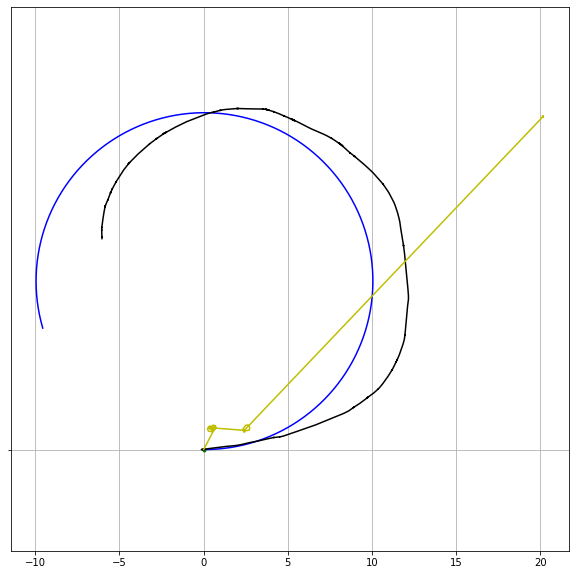

In [775]:
main()